## Convolutional Neural Networks and Computer Vision with PyTorch

In [72]:
import os
import pathlib
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from typing import Tuple, Dict, List
import random
from PIL import Image
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm.auto import tqdm
from timeit import default_timer as timer 
import pandas as pd
import torchvision

In [2]:
torch.__version__

'2.1.0+cpu'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Data preparation

In [4]:
# Create function
def walk_through_directory(dir_path):
    for dir_path, dir_name, file_name in os.walk(dir_path):
        print(f"There are {len(dir_name)} directories and {len(file_name)} images in '{dir_path}'.")
        
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    
    return classes, class_to_idx

def plot_transformed_image(image_path, transform, n = 3, seed = 42):
    random.seed(seed)
    random_image_path = random.sample(image_path, k = n)
    for image_path in random_image_path:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0)
            
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)
            
def display_random_image(dataset: torch.utils.data.dataset.Dataset, classes: List[str] = None,
    n: int = 10, display_shape: bool = True, seed: int = None):
    
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    if seed:
        random.seed(seed)

    random_sample_idx = random.sample(range(len(dataset)), k = n)

    plt.figure(figsize = (16, 8))

    for i, target_sample in enumerate(random_sample_idx):
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]
        target_image_adjust = target_image.permute(1, 2, 0)

        plt.subplot(1, n, i + 1)
        plt.imshow(target_image_adjust)
        plt.axis("off")
        
        if classes:
            title = f"class: {classes[target_label]}"
            
            if display_shape:
                title = title + f"\nshape: {target_image_adjust.shape}"
                
        plt.title(title)

In [5]:
# Create class
class ImageFolderCustom(Dataset):
    def __init__(self, target_path: str, transform = None) -> None:
        self.path = list(pathlib.Path(target_path).glob("*/*.jpg"))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(target_path)
        
    def load_image(self, index: int) -> Image.Image:
        image_path = self.path[index]

        return Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.path)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.path[index].parent.name
        class_idx = self.class_to_idx[class_name]
        
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx

In [6]:
# Initialize data, image, train and test path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
train_path, test_path = image_path / "train", image_path / "test"

train_path, test_path

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [7]:
walk_through_directory(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


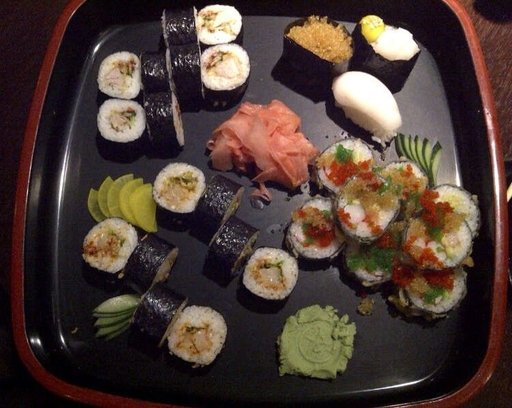

In [8]:
# View random image
random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem

image = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {image.height}") 
print(f"Image width: {image.width}")

image

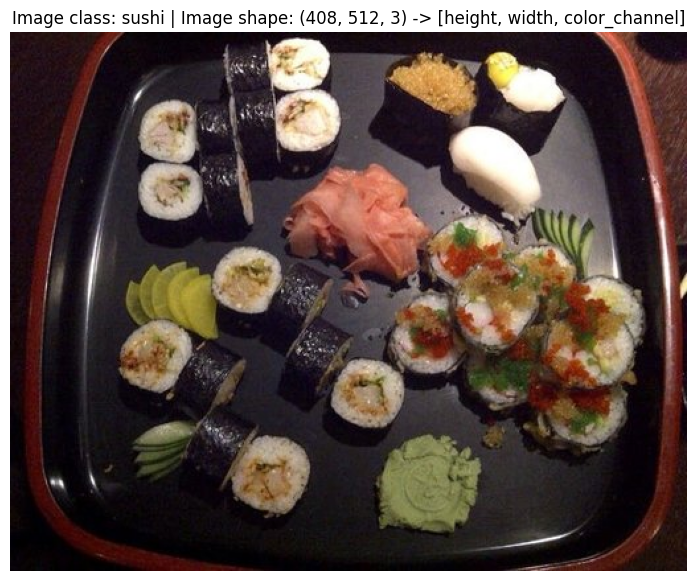

In [9]:
# View random image
image_as_array = np.asarray(image)

plt.figure(figsize = (10, 7))
plt.imshow(image_as_array)
plt.title(f"Image class: {image_class} | Image shape: {image_as_array.shape} -> [height, width, color_channel]")
plt.axis(False);

#### 1.1 Transforming image data
Utilize `torchvision.transforms` for image transformation

In [10]:
# Transformation function
data_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

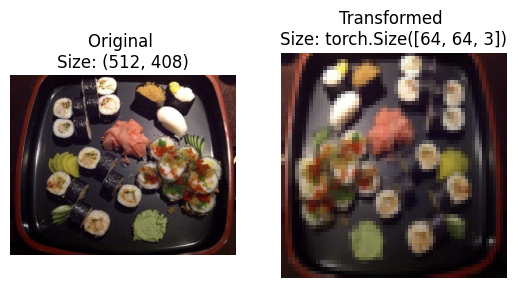

In [11]:
# Plotting random image and view after transformation
random.seed(42)

random_image_path = random.sample(image_path_list, k = 1)
random_image = random_image_path[0]

with Image.open(random_image) as f:
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(f) 
    ax[0].set_title(f"Original \nSize: {f.size}")
    ax[0].axis("off")
    
    # Change shape of image from C, H, W to H, W, C to suit matplotlib 
    transformed_image = data_transform(f).permute(1, 2, 0) 
    
    ax[1].imshow(transformed_image) 
    ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
    ax[1].axis("off")

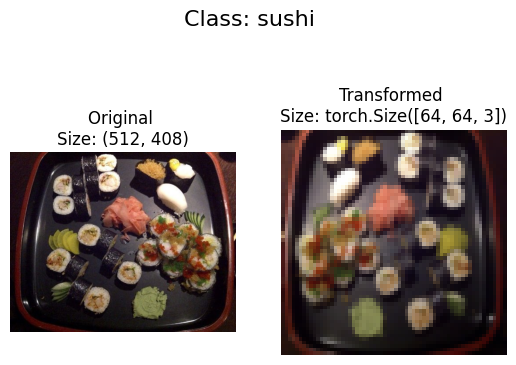

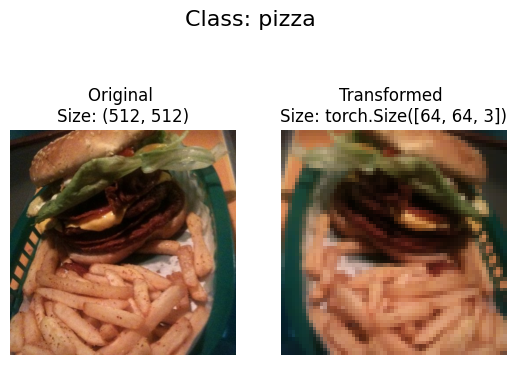

In [12]:
# Use function to plotting
plot_transformed_image(image_path_list, transform = data_transform, n = 2)

#### 1.2 ImageFolder to load image data

Utilize `torchvision.datasets.ImageFolder` to load image data

In [13]:
train_data = datasets.ImageFolder(root = train_path,
                                  transform = data_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root = test_path, 
                                 transform = data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
# View class
class_name = train_data.classes
class_name

['pizza', 'steak', 'sushi']

In [15]:
# View class in dictionary
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# How many sample of train and test
len(train_data), len(test_data)

(225, 75)

In [17]:
# View first traind data
image, label = train_data[0][0], train_data[0][1]

print(f"Image tensor:\n{image}")
print(f"Image shape: {image.shape}")
print(f"Image datatype: {image.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channel, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channel]


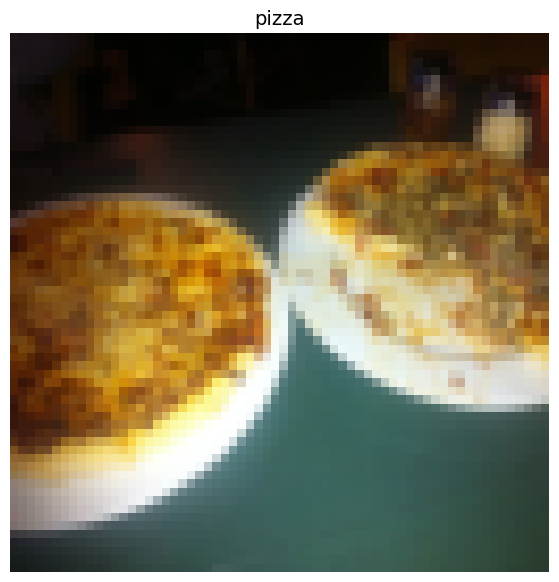

In [18]:
# View first image of train data
image_permute = image.permute(1, 2, 0)

print(f"Original shape: {image.shape} -> [color_channel, height, width]")
print(f"Image permute shape: {image_permute.shape} -> [height, width, color_channel]")

# Plot the image
plt.figure(figsize = (10, 7))
plt.imshow(image.permute(1, 2, 0))
plt.axis("off")
plt.title(class_name[label], fontsize = 14);

In [19]:
# Turn train and test dataset into DataLoader
train_dataloader = DataLoader(dataset = train_data, batch_size = 5,
    num_workers = 1, shuffle = True)

test_dataloader = DataLoader(dataset = test_data, batch_size = 5, 
    num_workers = 1, shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x154be0d4a60>,
 <torch.utils.data.dataloader.DataLoader at 0x154bab94f10>)

In [20]:
image, label = next(iter(train_dataloader))

print(f"Image shape: {image.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([5, 3, 64, 64]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([5])


#### 1.3 Loading image data with custom function

In [21]:
custom_train_data = ImageFolderCustom(target_path = train_path, transform = train_transform)
custom_test_data = ImageFolderCustom(target_path = test_path, transform = test_transform)

custom_train_data, custom_test_data

(<__main__.ImageFolderCustom at 0x154be0d4a90>,
 <__main__.ImageFolderCustom at 0x154be0d4eb0>)

In [22]:
len(custom_train_data), len(custom_test_data)

(225, 75)

In [23]:
custom_train_data.classes

['pizza', 'steak', 'sushi']

In [24]:
custom_train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [25]:
# Check equality of custom Dataset and ImageFolder Dataset
print((len(custom_train_data) == len(train_data)) & (len(custom_test_data) == len(test_data)))
print(custom_train_data.classes == train_data.classes)
print(custom_train_data.class_to_idx == train_data.class_to_idx)

True
True
True


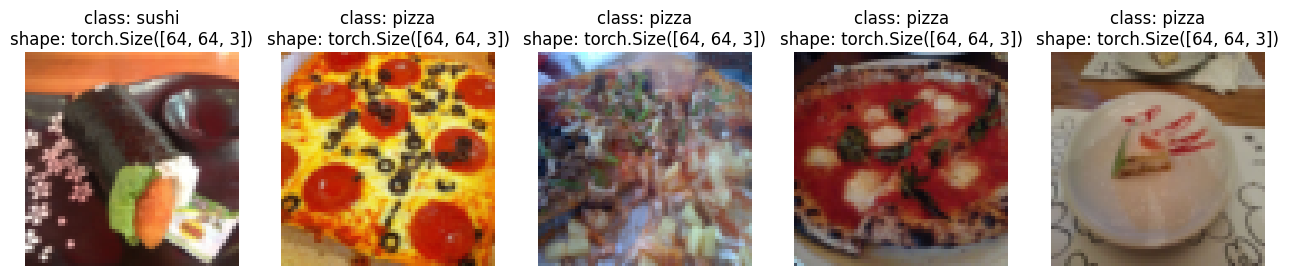

In [26]:
display_random_image(train_data, n = 5, classes = class_name, seed = None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


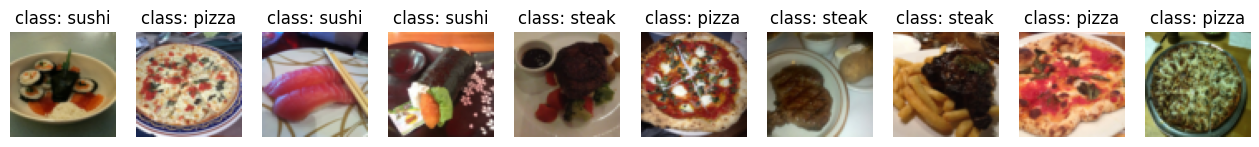

In [27]:
display_random_image(custom_train_data, n = 12, classes = class_name, seed = None)

In [28]:
# Turn custom loaded image into DataLoader
custom_train_dataloader = DataLoader(dataset = custom_train_data, batch_size = 1,
    num_workers = 0, shuffle = True)

custom_test_dataloader = DataLoader(dataset = custom_test_data, batch_size = 1, 
    num_workers = 0, shuffle = False)

custom_train_dataloader, custom_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x154a1367af0>,
 <torch.utils.data.dataloader.DataLoader at 0x154bdfd2460>)

In [29]:
custom_image, custom_label = next(iter(custom_train_dataloader))

print(f"Image shape: {custom_image.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {custom_label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([1])


In [30]:
# Incorporate transforms.TrivialAugmentWide()
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

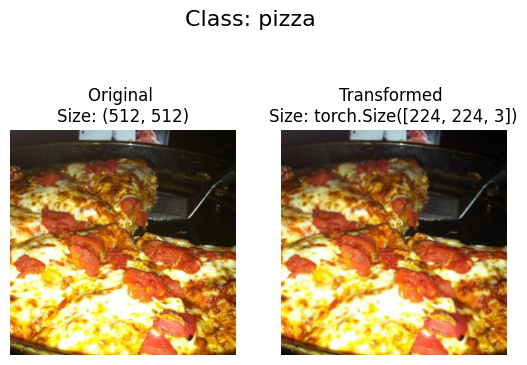

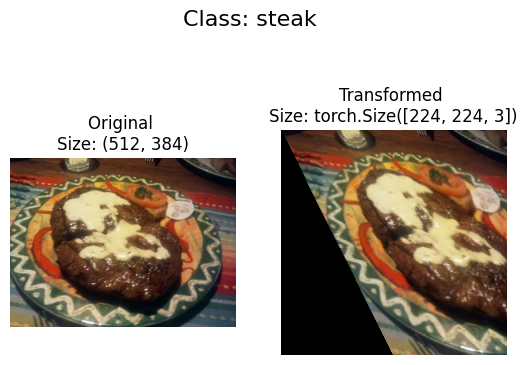

In [31]:
image_path_list = list(image_path.glob("*/*/*.jpg"))

plot_transformed_image(image_path = image_path_list,
    transform = train_transform, n = 2, seed = None
)

### 2. Model building

In [107]:
# Function creation
def model_training(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
                   loss_function: torch.nn.Module, optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_accuracy = 0, 0
    
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        
        loss = loss_function(y_pred, y)
        train_loss += loss.item() 

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
        train_accuracy += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    
    return train_loss, train_accuracy

def model_testing(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, 
                  loss_function: torch.nn.Module):
    model.eval() 
    test_loss, test_accuracy = 0, 0
    
    with torch.inference_mode():
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            test_pred_logit = model(x)

            loss = loss_function(test_pred_logit, y)
            test_loss += loss.item()
            
            test_pred_label = test_pred_logit.argmax(dim = 1)
            test_accuracy += ((test_pred_label == y).sum().item() / len(test_pred_label))
            
    test_loss = test_loss / len(dataloader)
    test_accuracy = test_accuracy / len(dataloader)
    
    return test_loss, test_accuracy

def start_training(model: torch.nn.Module, train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, optimizer: torch.optim.Optimizer,
          loss_function: torch.nn.Module = nn.CrossEntropyLoss(), epoch_number: int = 5):
    result = { "train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": [] }
    
    for epoch in tqdm(range(epoch_number)):
        train_loss, train_accuracy = model_training(model = model, dataloader = train_dataloader,
                    loss_function = loss_function, optimizer = optimizer)
        test_loss, test_accuracy = model_testing(model = model, dataloader = test_dataloader,
                    loss_function = loss_function)
        
        print(f"Epoch: {epoch + 1} | train_loss: {train_loss:.4f} | train_accuracy: {train_accuracy:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_accuracy: {test_accuracy:.4f}")
        
        result["train_loss"].append(train_loss)
        result["train_accuracy"].append(train_accuracy)
        result["test_loss"].append(test_loss)
        result["test_accuracy"].append(test_accuracy)
    
    return result

def plot_loss_curves(result: Dict[str, List[float]]):
    train_loss = result['train_loss']
    test_loss = result['test_loss']

    train_accuracy = result['train_accuracy']
    test_accuracy = result['test_accuracy']

    epoch_number = range(len(result['train_loss']))

    plt.figure(figsize = (15, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(epoch_number, train_loss, label = 'train_loss')
    plt.plot(epoch_number, test_loss, label = 'test_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_number, train_accuracy, label = 'train_accuracy')
    plt.plot(epoch_number, test_accuracy, label = 'test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend();
    
def pred_and_plot_image(model: torch.nn.Module, image_path: str, 
    class_name: List[str] = None, transform = None, device: torch.device = device):
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    target_image = target_image / 255. 
    
    if transform:
        target_image = transform(target_image)
    
    model.to(device)
    
    model.eval()
    with torch.inference_mode():
        target_image = target_image.unsqueeze(dim = 0)
        target_image_pred = model(target_image.to(device))

    target_image_pred_prob = torch.softmax(target_image_pred, dim = 1)
    target_image_pred_label = torch.argmax(target_image_pred_prob, dim = 1)
    
    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    
    if class_name:
        title = f"Pred: {class_name[target_image_pred_label.cpu()]} | Prob: {target_image_pred_prob.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_prob.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [47]:
# TinyVGG model creation
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_unit: int, output_shape: int) -> None:
        super().__init__()
        self.cnn_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels = hidden_unit, kernel_size = 3,
                      stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_unit, out_channels = hidden_unit, kernel_size = 3,
                        stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )
        self.cnn_block_2 = nn.Sequential(
            nn.Conv2d(hidden_unit, hidden_unit, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(hidden_unit, hidden_unit, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = hidden_unit * 16 * 16, out_features = output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.cnn_block_1(x)
        x = self.cnn_block_2(x)
        x = self.classifier(x)
        return x

#### 2.1. First model without data augmentation

In [48]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [49]:
simple_train_data = datasets.ImageFolder(root = train_path, transform = simple_transform)
simple_test_data = datasets.ImageFolder(root = test_path, transform = simple_transform)

In [50]:
batch_size = 32
worker_number = os.cpu_count()

print(f"Creating DataLoader's with batch size {batch_size} and {worker_number} worker.")

simple_train_dataloader = DataLoader(simple_train_data, batch_size = batch_size, 
    shuffle = True, num_workers = worker_number)
simple_test_dataloader = DataLoader(simple_test_data, batch_size = batch_size, 
    shuffle = False, num_workers = worker_number)

simple_train_dataloader, simple_test_dataloader

Creating DataLoader's with batch size 32 and 8 worker.


(<torch.utils.data.dataloader.DataLoader at 0x154ba897790>,
 <torch.utils.data.dataloader.DataLoader at 0x154bcc7ae80>)

In [51]:
torch.manual_seed(42)

first_model = TinyVGG(input_shape = 3, hidden_unit = 10, 
                  output_shape = len(train_data.classes)).to(device)
first_model

TinyVGG(
  (cnn_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [52]:
image_batch, label_batch = next(iter(simple_train_dataloader))
single_image, single_label = image_batch[0].unsqueeze(dim = 0), label_batch[0]

print(f"Single image shape: {single_image.shape}\n")

first_model.eval()

with torch.inference_mode():
    pred = first_model(single_image.to(device))
    
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim = 1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim = 1), dim=1)}\n")
print(f"Actual label:\n{single_label}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0578, 0.0634, 0.0351]])

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]])

Output prediction label:
tensor([1])

Actual label:
2


In [53]:
summary(first_model, input_size = [1, 3, 64, 64]) 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [54]:
torch.manual_seed(42) 
# torch.cuda.manual_seed(42)

epoch_number = 5

first_model = TinyVGG(input_shape = 3, hidden_unit = 10, 
                      output_shape = len(train_data.classes)).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = first_model.parameters(), lr = 0.001)

start_time = timer()

first_model_result = start_training(model = first_model, 
        train_dataloader = simple_train_dataloader, test_dataloader = simple_test_dataloader,
        optimizer = optimizer, loss_function = loss_function, 
                        epoch_number = epoch_number)

end_time = timer()

print(f"Total training time: {end_time - start_time:.3f} seconds")

 20%|██        | 1/5 [00:14<00:59, 14.77s/it]

Epoch: 1 | train_loss: 1.1078 | train_accuracy: 0.2578 | test_loss: 1.1362 | test_accuracy: 0.2604


 40%|████      | 2/5 [00:29<00:43, 14.47s/it]

Epoch: 2 | train_loss: 1.0846 | train_accuracy: 0.4258 | test_loss: 1.1622 | test_accuracy: 0.1979


 60%|██████    | 3/5 [00:43<00:28, 14.33s/it]

Epoch: 3 | train_loss: 1.1153 | train_accuracy: 0.2930 | test_loss: 1.1696 | test_accuracy: 0.1979


 80%|████████  | 4/5 [00:57<00:14, 14.26s/it]

Epoch: 4 | train_loss: 1.0988 | train_accuracy: 0.4141 | test_loss: 1.1344 | test_accuracy: 0.1979


100%|██████████| 5/5 [01:11<00:00, 14.27s/it]

Epoch: 5 | train_loss: 1.0990 | train_accuracy: 0.2930 | test_loss: 1.1434 | test_accuracy: 0.1979
Total training time: 71.348 seconds


In [55]:
first_model_result.keys()

dict_keys(['train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'])

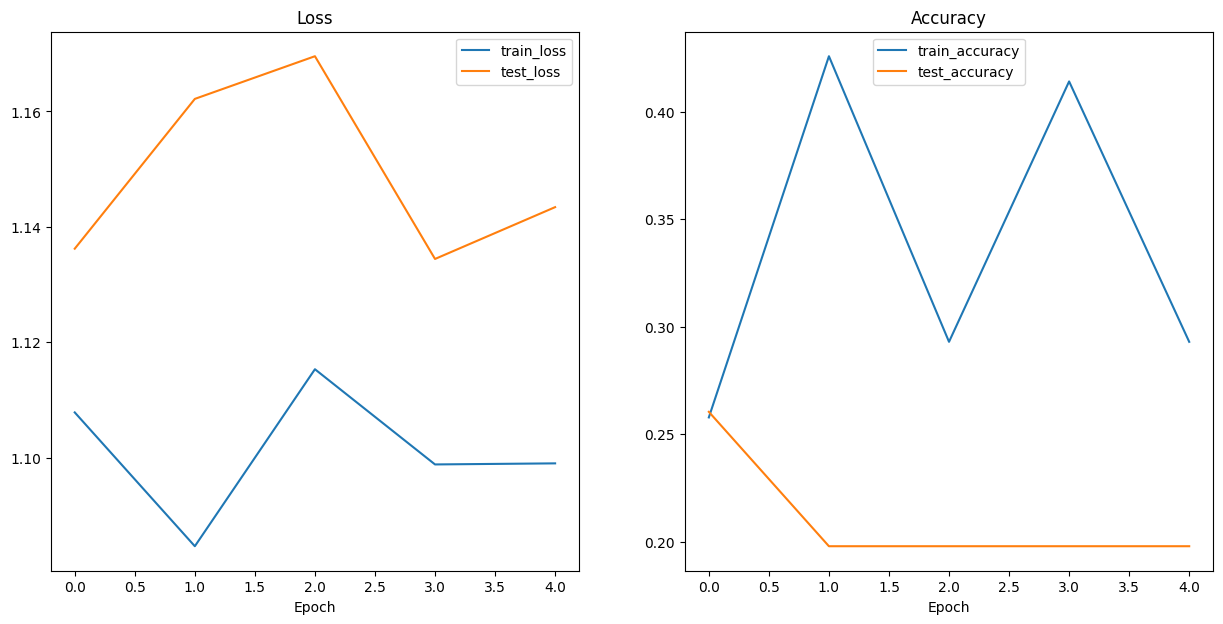

In [57]:
plot_loss_curves(first_model_result)

#### 2.1. Second model with data augmentation

In [59]:
trivial_augment_train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor() 
])

test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [60]:
augmented_train_data = datasets.ImageFolder(train_path, transform = trivial_augment_train_transform)
simple_test_data = datasets.ImageFolder(test_path, transform = test_transform)

augmented_train_data, simple_test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [62]:
batch_size = 32
worker_number = os.cpu_count()

torch.manual_seed(42)

augmented_train_dataloader = DataLoader(augmented_train_data, batch_size = batch_size, 
    shuffle = True, num_workers = worker_number)
simple_test_dataloader = DataLoader(simple_test_data, batch_size = batch_size, 
    shuffle = False, num_workers = worker_number)

augmented_train_dataloader, simple_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x154be5d15b0>,
 <torch.utils.data.dataloader.DataLoader at 0x154be6496d0>)

In [63]:
torch.manual_seed(42)

second_model = TinyVGG(input_shape = 3, hidden_unit = 10, 
                  output_shape = len(train_data.classes)).to(device)
second_model

TinyVGG(
  (cnn_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [64]:
torch.manual_seed(42) 
# torch.cuda.manual_seed(42)

epoch_number = 5

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = second_model.parameters(), lr = 0.001)

start_time = timer()

second_model_result = start_training(model = second_model, 
        train_dataloader = augmented_train_dataloader, test_dataloader = simple_test_dataloader,
        optimizer = optimizer, loss_function = loss_function, 
                        epoch_number = epoch_number)

end_time = timer()

print(f"Total training time: {end_time - start_time:.3f} seconds")

 20%|██        | 1/5 [00:15<01:01, 15.38s/it]

Epoch: 1 | train_loss: 1.1074 | train_accuracy: 0.2500 | test_loss: 1.1059 | test_accuracy: 0.2604


 40%|████      | 2/5 [00:30<00:45, 15.18s/it]

Epoch: 2 | train_loss: 1.0790 | train_accuracy: 0.4258 | test_loss: 1.1384 | test_accuracy: 0.2604


 60%|██████    | 3/5 [00:44<00:29, 14.83s/it]

Epoch: 3 | train_loss: 1.0802 | train_accuracy: 0.4258 | test_loss: 1.1695 | test_accuracy: 0.2604


 80%|████████  | 4/5 [01:00<00:14, 14.99s/it]

Epoch: 4 | train_loss: 1.1287 | train_accuracy: 0.3047 | test_loss: 1.1620 | test_accuracy: 0.2604


100%|██████████| 5/5 [01:15<00:00, 15.13s/it]

Epoch: 5 | train_loss: 1.0885 | train_accuracy: 0.4258 | test_loss: 1.1476 | test_accuracy: 0.2604
Total training time: 75.677 seconds


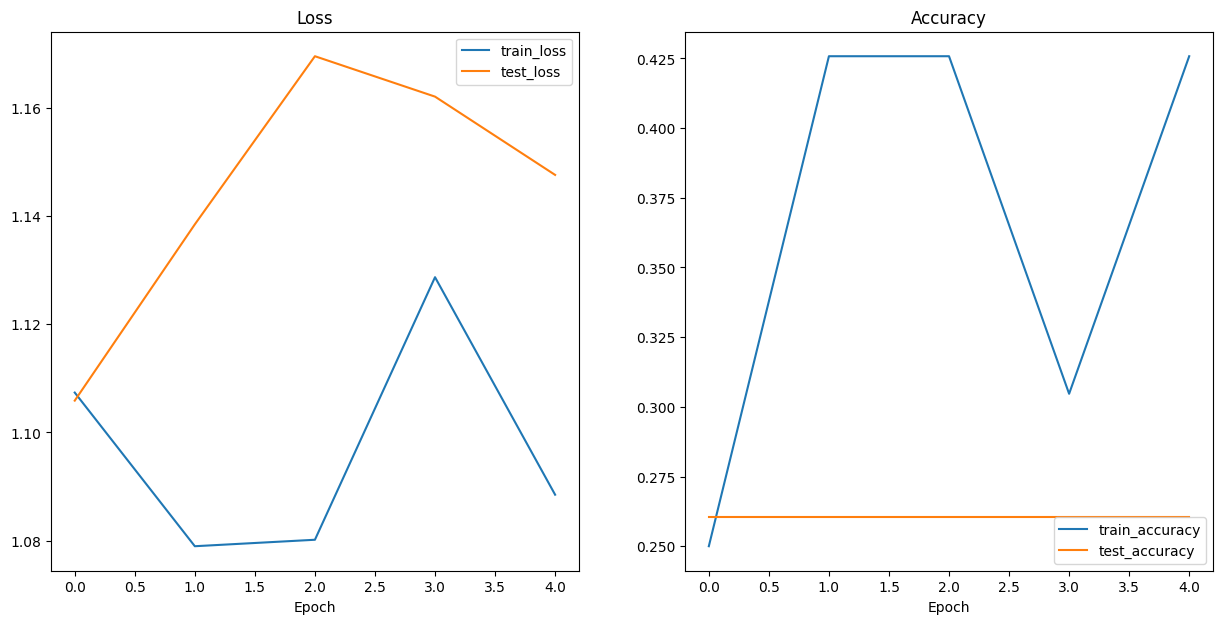

In [65]:
plot_loss_curves(second_model_result)

In [67]:
first_model_df = pd.DataFrame(first_model_result)
second_model_df = pd.DataFrame(second_model_result)

first_model_df

,train_loss,train_accuracy,test_loss,test_accuracy
0,1.107836,0.257812,1.136208,0.260417
1,1.084645,0.425781,1.162168,0.197917
2,1.115319,0.292969,1.169564,0.197917
3,1.098818,0.414062,1.134429,0.197917
4,1.099004,0.292969,1.143407,0.197917


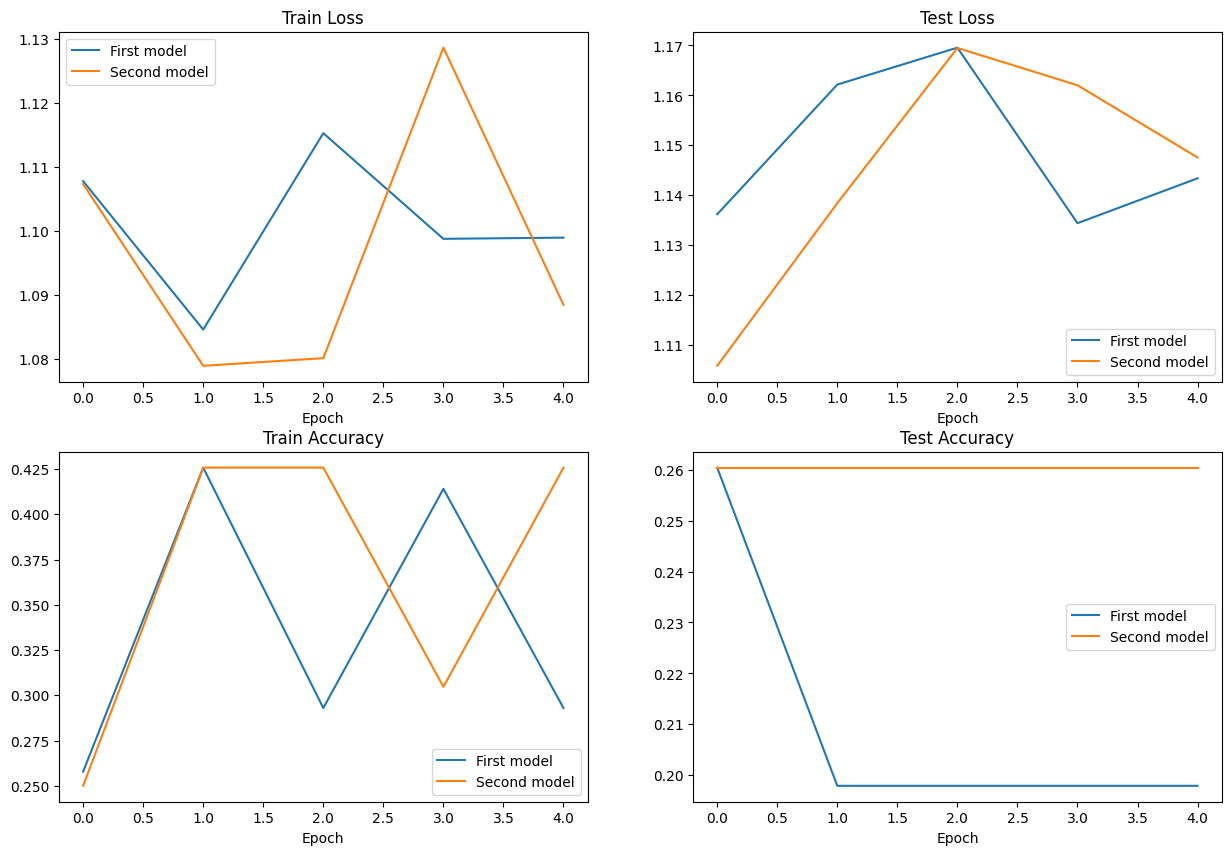

In [68]:
plt.figure(figsize = (15, 10))

epoch_number = range(len(first_model_df))

plt.subplot(2, 2, 1)
plt.plot(epoch_number, first_model_df["train_loss"], label = "First model")
plt.plot(epoch_number, second_model_df["train_loss"], label = "Second model")
plt.title("Train Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epoch_number, first_model_df["test_loss"], label = "First model")
plt.plot(epoch_number, second_model_df["test_loss"], label = "Second model")
plt.title("Test Loss")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epoch_number, first_model_df["train_accuracy"], label = "First model")
plt.plot(epoch_number, second_model_df["train_accuracy"], label = "Second model")
plt.title("Train Accuracy")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epoch_number, first_model_df["test_accuracy"], label = "First model")
plt.plot(epoch_number, second_model_df["test_accuracy"], label = "Second model")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.legend();

Turn JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale torch.Tensor with values of datatype uint8 in range [0, 255].

In [74]:
custom_image_path = data_path / "04-pizza-dad.jpeg"

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

In [79]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)
custom_image = custom_image / 255.

print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

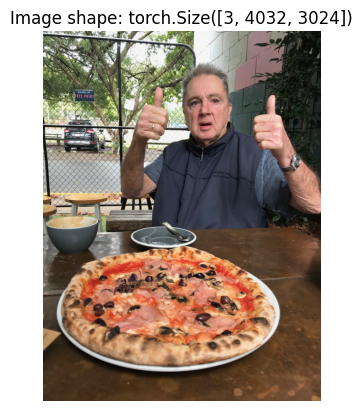

In [81]:
plt.imshow(custom_image.permute(1, 2, 0))
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [82]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


C:\Users\Chris\anaconda3\envs\tensorflow\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [91]:
custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim = 0).to(device)

In [92]:
first_model.eval()

with torch.inference_mode():
    first_custom_image_pred = first_model(custom_image_transformed_with_batch_size)

In [93]:
second_model.eval()

with torch.inference_mode():
    second_custom_image_pred = second_model(custom_image_transformed_with_batch_size)

In [101]:
print(f"First prediction logit: {first_custom_image_pred}")
print(f"Second prediction logit: {second_custom_image_pred}")

# Convert logit -> prediction probabilities
# Using torch.softmax() for multi-class classification
first_custom_image_pred_prob = torch.softmax(first_custom_image_pred, dim = 1)
second_custom_image_pred_prob = torch.softmax(second_custom_image_pred, dim = 1)

print(f"First prediction probability: {first_custom_image_pred_prob}")
print(f"Second prediction probability: {second_custom_image_pred_prob}")

# Convert prediction probability -> prediction label
first_custom_image_pred_label = torch.argmax(first_custom_image_pred_prob, dim = 1)
second_custom_image_pred_label = torch.argmax(second_custom_image_pred_prob, dim = 1)

print(f"First prediction label: {first_custom_image_pred_label}")
print(f"Second prediction label: {second_custom_image_pred_label}")

First prediction logit: tensor([[ 0.0207,  0.0759, -0.1372]])
Second prediction logit: tensor([[ 0.1143,  0.0257, -0.1387]])
First prediction probability: tensor([[0.3435, 0.3631, 0.2934]])
Second prediction probability: tensor([[0.3715, 0.3400, 0.2885]])
First prediction label: tensor([1])
Second prediction label: tensor([0])


In [105]:
# What is the class name predicted by first model?
first_custom_image_pred_class = class_name[first_custom_image_pred_label.cpu()]
first_custom_image_pred_class

'steak'

In [106]:
# What is the class name predicted by second model?
second_custom_image_pred_class = class_name[second_custom_image_pred_label.cpu()]
second_custom_image_pred_class

'pizza'

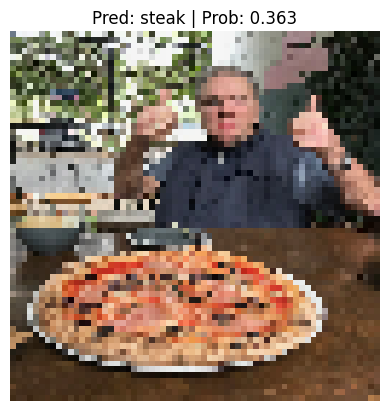

In [108]:
pred_and_plot_image(model = first_model, image_path = custom_image_path, 
                    class_name = class_name, transform = custom_image_transform, device = device)